<a href="https://colab.research.google.com/github/navrat/EVA_phase1_2022_23/blob/main/S4_coding_drilldown_code/EVA4S5F7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


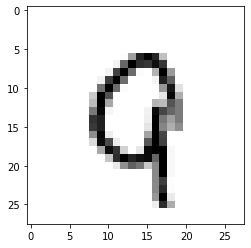

In [7]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

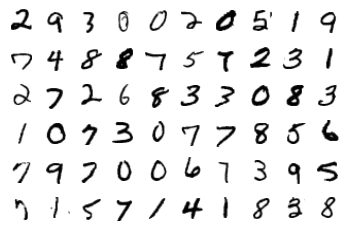

In [8]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 5
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 5
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
          Dropout-10           [-1, 20, 22, 22]               0
        MaxPool2d-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             200

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [12]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.10917504876852036 Batch_id=468 Accuracy=84.63: 100%|██████████| 469/469 [00:16<00:00, 28.21it/s]



Test set: Average loss: 0.2390, Accuracy: 9344/10000 (93.44%)

EPOCH: 1


Loss=0.08443698287010193 Batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:20<00:00, 23.19it/s]



Test set: Average loss: 0.0849, Accuracy: 9768/10000 (97.68%)

EPOCH: 2


Loss=0.038218799978494644 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:18<00:00, 24.79it/s]



Test set: Average loss: 0.1342, Accuracy: 9577/10000 (95.77%)

EPOCH: 3


Loss=0.05233585834503174 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:15<00:00, 31.17it/s]



Test set: Average loss: 0.0486, Accuracy: 9859/10000 (98.59%)

EPOCH: 4


Loss=0.04762789234519005 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:13<00:00, 33.83it/s]



Test set: Average loss: 0.0490, Accuracy: 9853/10000 (98.53%)

EPOCH: 5


Loss=0.09325046092271805 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:13<00:00, 33.88it/s]



Test set: Average loss: 0.0561, Accuracy: 9839/10000 (98.39%)

EPOCH: 6


Loss=0.09290965646505356 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:14<00:00, 31.36it/s]



Test set: Average loss: 0.0522, Accuracy: 9838/10000 (98.38%)

EPOCH: 7


Loss=0.10173875838518143 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:14<00:00, 33.37it/s]



Test set: Average loss: 0.0469, Accuracy: 9856/10000 (98.56%)

EPOCH: 8


Loss=0.10698432475328445 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:15<00:00, 31.13it/s]



Test set: Average loss: 0.0389, Accuracy: 9881/10000 (98.81%)

EPOCH: 9


Loss=0.014177526347339153 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:14<00:00, 33.35it/s]



Test set: Average loss: 0.0453, Accuracy: 9861/10000 (98.61%)

EPOCH: 10


Loss=0.039018575102090836 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:14<00:00, 33.39it/s]



Test set: Average loss: 0.0411, Accuracy: 9869/10000 (98.69%)

EPOCH: 11


Loss=0.020526355132460594 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:15<00:00, 30.46it/s]



Test set: Average loss: 0.0438, Accuracy: 9869/10000 (98.69%)

EPOCH: 12


Loss=0.02107331156730652 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:14<00:00, 33.20it/s]



Test set: Average loss: 0.0334, Accuracy: 9895/10000 (98.95%)

EPOCH: 13


Loss=0.04048018902540207 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 32.92it/s]



Test set: Average loss: 0.0480, Accuracy: 9855/10000 (98.55%)

EPOCH: 14


Loss=0.07846098393201828 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:14<00:00, 32.84it/s]



Test set: Average loss: 0.0278, Accuracy: 9921/10000 (99.21%)

EPOCH: 15


Loss=0.00513942027464509 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]



Test set: Average loss: 0.0524, Accuracy: 9844/10000 (98.44%)

EPOCH: 16


Loss=0.05183107778429985 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:14<00:00, 32.95it/s]



Test set: Average loss: 0.0298, Accuracy: 9904/10000 (99.04%)

EPOCH: 17


Loss=0.0342424176633358 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.69it/s]



Test set: Average loss: 0.0312, Accuracy: 9903/10000 (99.03%)

EPOCH: 18


Loss=0.03007194586098194 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 33.25it/s]



Test set: Average loss: 0.0293, Accuracy: 9915/10000 (99.15%)

EPOCH: 19


Loss=0.025384655222296715 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 33.09it/s]



Test set: Average loss: 0.0329, Accuracy: 9896/10000 (98.96%)



Text(0.5, 1.0, 'Test Accuracy')

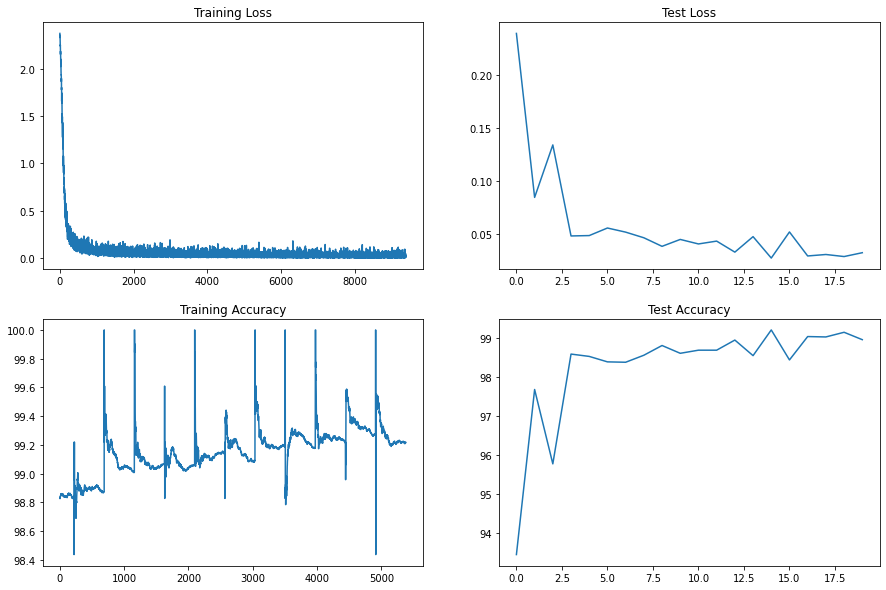

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([t.cpu().item() for t in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Target:
- Increase model capacity. Add more layers at the end. 

Result:
- Parameters: 11.9k
- Best Train Accuracy: 99.33
- Best Test Accuracy: 99.04

Analysis:
- The model still showing over-fitting, possibly DropOut is not working as expected! Wait yes! We don't know which layer is causing over-fitting. Adding it to a specific layer wasn't a great idea. 
- Quite Possibly we need to add more capacity, especially at the end. 
- Closer analysis of MNIST can also reveal that just at RF of 5x5 we start to see patterns forming. 
- We can also increase the capacity of the model by adding a layer after GAP!